# Bayesian optimization

**Problem**:
- Many optimization problems in machine learning are black box optimization problems where the objective function $f(x)$ is a black box function. 
-  We do not have an analytical expression for $f$ nor do we know its derivatives. 
- Evaluation of the function is restricted to sampling at a point $x$ and getting a possibly noisy response.

If $f$ is **cheap** to evaluate we could sample at many points e.g. via **grid search, random search or numeric gradient estimation**

Ff function evaluation is **expensive** e.g. tuning hyperparameters of a deep neural network, probe drilling for oil at given geographic coordinates or evaluating the effectiveness of a drug candidate taken from a chemical search space then it is important to minimize the number of samples drawn from the black box function $f$.

**Bayesian optimization** attempt to find the global optimimum in a minimum number of steps. 
Bayesian optimization incorporates **prior belief** about $f$ and updates the prior with samples drawn from $f$ to get a **posterior** that better approximates f. 

The model used for approximating the objective function is called **surrogate model**. 

Bayesian optimization also uses an **acquisition function** that directs sampling to areas where an improvement over the current best observation is likely.


### Surrogate model

A popular surrogate model for Bayesian optimization are **Gaussian processes** (GPs). 

**GPs** define a prior over functions and we can use them to incorporate prior beliefs about the objective function (smoothness, ...). 
The GP posterior is cheap to evaluate and is used to propose points in the search space where sampling is likely to yield an improvement.

### Acquisition functions

Proposing sampling points in the search space is done by **acquisition functions**. They trade off **exploitation and exploration**. 

**Exploitation** means sampling where the surrogate model predicts a high objective and **exploration** means sampling at locations where the prediction uncertainty is high. 

Both correspond to high acquisition function values and the goal is to maximize the acquisition function to determine the next sampling point.

More formally, the objective function $f$ will be sampled at $x_t=argmax_{x}u(x|D_{1:t−1})$ where $u$ is the acquisition function and $D_{1:t−1}={(x_1,y_1),...,(x_{t−1},y_{t−1})}$ are the $t−1$ samples drawn from f so far. 

Popular acquisition functions are :
 - maximum probability of improvement (MPI)
 - expected improvement (EI)
 - upper confidence bound (UCB). 
 
 In the following, we will use the expected improvement (EI) which is most widely used and described further below.

### Optimization algorithm

The **Bayesian optimization** procedure is as follows. For $t=1,2,...$ repeat:
- Find the next sampling point $x_t$ by optimizing the acquisition function over the $GP: x_t=argmax_{x}u(x|D_{1:t−1})$
- Obtain a possibly noisy sample $y_t=f(x_t)+ϵ_t$ from the objective function $f$.
- Add the sample to previous samples $D_{1:t}={D_{1:t−1},(x_t,y_t)}$ and update the GP.

### Expected improvement 

Expected improvement  is defined as
$EI(x)=E[max(f(x)−f(x^+),0)]$

where $f(x^+)$ is the value of the best sample so far and $x^+$ is the location of that sample i.e. $x^+ = argmax_{x_i \in x_{1:t}}f(x_i)$

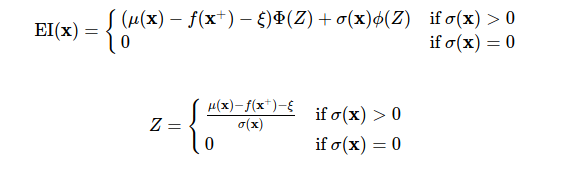

where $μ(x)$ and $σ(x)$ are the mean and the standard deviation of the GP posterior predictive at x, respectively. $Φ$ and $ϕ$ are the CDF and PDF of the standard normal distribution, respectively. The first summation term is the exploitation term and second summation term is the exploration term.

Parameter $ξ$ determines the amount of exploration during optimization and higher $ξ$ values lead to more exploration. 

In other words, with increasing $ξ$ values, the importance of improvements predicted by the GP posterior mean $μ(x)$ decreases relative to the importance of potential improvements in regions of high prediction uncertainty, represented by large $σ(x)$ values. A recommended default value for $ξ$ is 0.01.

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

%matplotlib inline


def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1) 
    plt.plot(X, Y, 'y--', lw=1, label='Noise-free objective')
    plt.plot(X, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()    
        
def plot_convergence(X_sample, Y_sample, n_init=2):
    plt.figure(figsize=(12, 3))

    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x)+1)
    
    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    y_max_watermark = np.maximum.accumulate(y)
    
    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, 'bo-')
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Distance between consecutive x\'s')

    plt.subplot(1, 2, 2)
    plt.plot(r, y_max_watermark, 'ro-')
    plt.xlabel('Iteration')
    plt.ylabel('Best Y')
    plt.title('Value of best selected sample')

In [68]:
noise = 0.2
def black_box(X, noise=noise):
    # Our black box function
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

In [80]:
bounds = np.array([[-1.0, 2.0]])

X_init = np.array([[2], [1.1]])
Y_init = black_box(X_init)

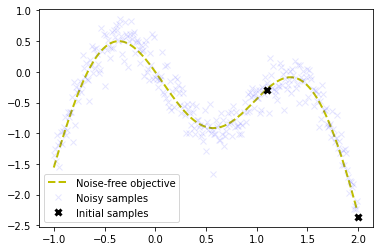

In [81]:
# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = black_box(X,0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, black_box(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

The goal is to find the global optimum on the left in a small number of steps.

The next step is to implement the acquisition function defined as `expected_improvement` function.

In [82]:
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, 1)
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    
    return ei

In [83]:
### We also need a function that proposes the next sampling point by computing the location of the acquisition function maximum. 
### Optimization is restarted n_restarts times to avoid local optima.

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)[0]
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

The Gaussian process in the following example is configured with a **Matérn kernel** which is a generalization of the squared exponential kernel or RBF kernel. The known noise level is configured with the alpha parameter.

Bayesian optimization runs for 10 iterations. 
In each iteration, a row with two plots is produced. The left plot shows the noise-free objective function, the surrogate function which is the GP posterior predictive mean, the 95% confidence interval of the mean and the noisy samples obtained from the objective function so far. The right plot shows the acquisition function. The vertical dashed line in both plots shows the proposed sampling point for the next iteration which corresponds to the maximum of the acquisition function.

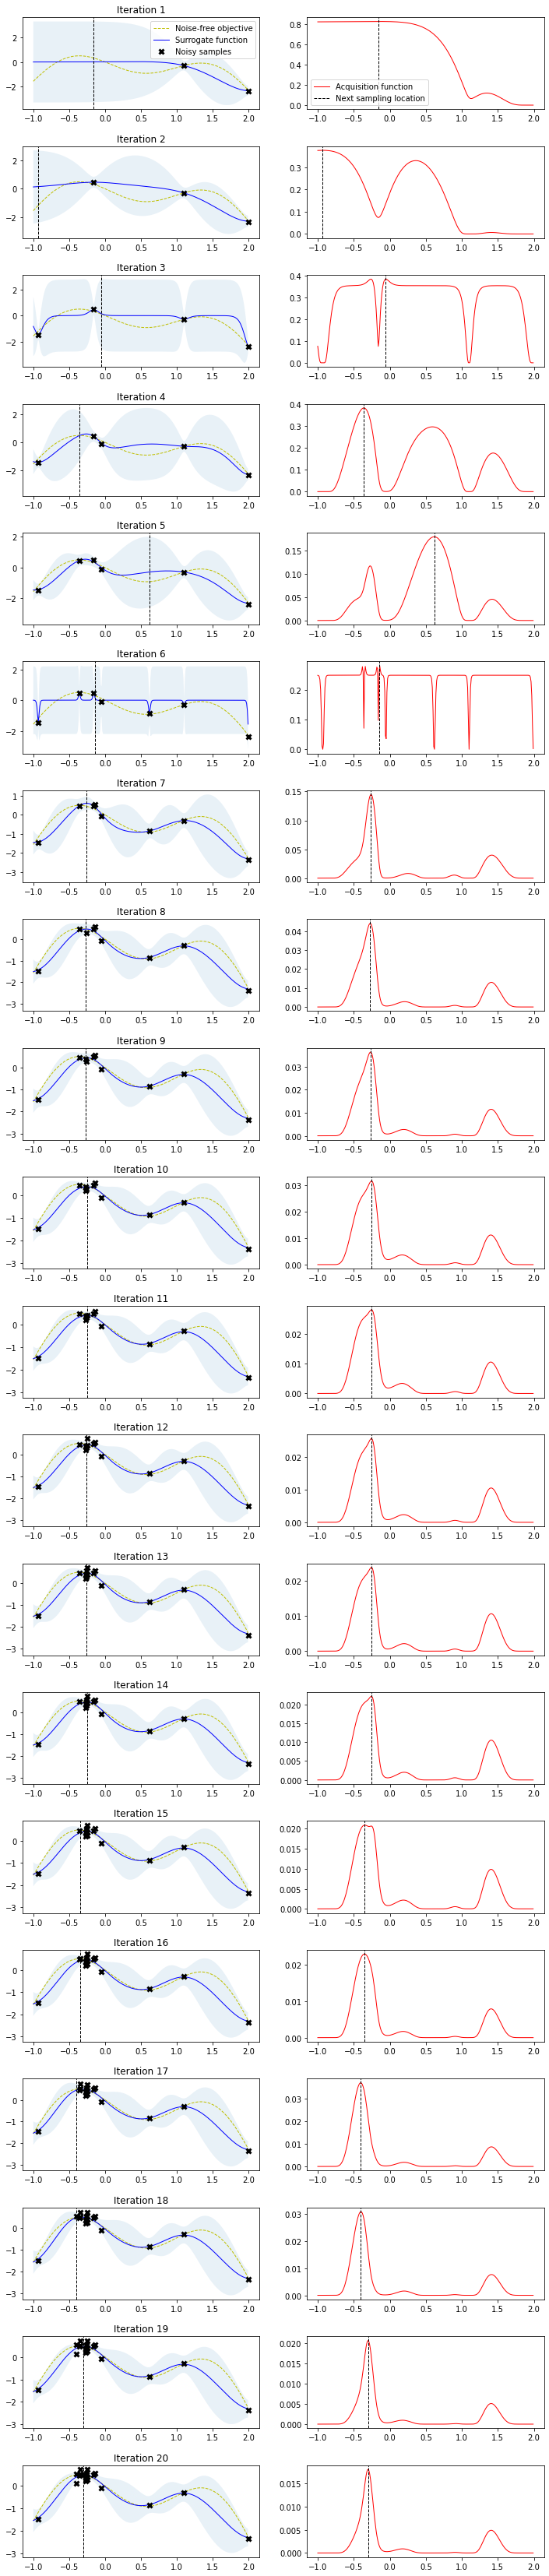

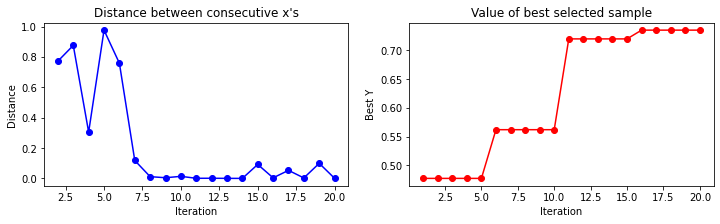

In [84]:

# Gaussian process with Matérn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 20

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    # Obtain next noisy sample from the objective function
    Y_next = black_box(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))
    
plot_convergence(X_sample, Y_sample)

### References

1. https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/dev/bayesian-optimization/bayesian_optimization.ipynb